# Install detectron2

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-9sv61_6h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-9sv61_6h
  Resolved https://github.com/facebookresearch/fvcore.git to commit 0f2b23b6f93e36041d9a74764ee824541cf0a0e5
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65266 sha256=ca99e57c9b8c81cf901613f95f1cd98aa4aeb8f9914fafc411775c619d7b6b32
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3pvgfu9/wheels/8f/cb/6a/3b7ac0e01781855ca3d1417ebf9e15e20d5b7fe37ab063aa50
Successfully built fvcore
  Attempting uninstall: fvcore
    Found existing installation: fvcore 0.1.5.post20221221
    Uninstalling fvcore-0.1.5.post20221221:
      Successfully uninstalled fvcore-0.1.5.post20221221
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

'2.0.1+cu118'

In [ ]:
!git clone https://github.com/somae604/Digital_Dentistry_Dataton.git dataton

Cloning into 'data'...
remote: Enumerating objects: 19609, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 19609 (delta 15), reused 6 (delta 0), pack-reused 19574
Receiving objects: 100% (19609/19609), 1.25 GiB | 16.59 MiB/s, done.
Resolving deltas: 100% (939/939), done.
Updating files: 100% (32813/32813), done.


In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15188, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 15188 (delta 117), reused 116 (delta 67), pack-reused 14979
Receiving objects: 100% (15188/15188), 6.21 MiB | 19.58 MiB/s, done.
Resolving deltas: 100% (10986/10986), done.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 773.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("teeths", {}, "/content/dataton/datasets/trainvals/trainval_c031.json", "/content/dataton/datasets/images")

In [ ]:
teeths_metadata = MetadataCatalog.get("teeths")
dataset_dicts = DatasetCatalog.get("teeths")

WARNING [08/15 13:09:30 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/15 13:09:30 d2.data.datasets.coco]: Loaded 712 images in COCO format from /content/data/datasets/trainvals/trainval_c031.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



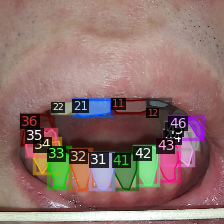

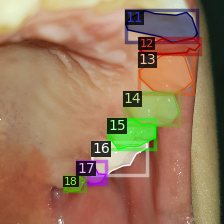

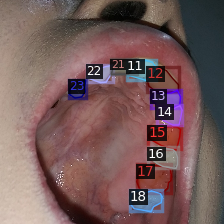

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=teeths_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("teeths",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 33  # 33 classes and if you use different trainval, change it

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/15 13:14:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 98.7MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[08/15 13:14:08 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/15 13:14:20 d2.utils.events]:  eta: 0:01:34  iter: 19  total_loss: 3.415  loss_cls: 1.713  loss_box_reg: 0.9084  loss_mask: 0.6866  loss_rpn_cls: 0.05912  loss_rpn_loc: 0.03819    time: 0.3306  last_time: 0.3161  data_time: 0.0288  last_data_time: 0.0217   lr: 0.0012854  max_mem: 1769M
[08/15 13:14:31 d2.utils.events]:  eta: 0:01:28  iter: 39  total_loss: 2.74  loss_cls: 1.165  loss_box_reg: 0.9411  loss_mask: 0.5526  loss_rpn_cls: 0.02849  loss_rpn_loc: 0.04192    time: 0.3379  last_time: 0.3243  data_time: 0.0122  last_data_time: 0.0128   lr: 0.0026174  max_mem: 1771M
[08/15 13:14:38 d2.utils.events]:  eta: 0:01:23  iter: 59  total_loss: 2.475  loss_cls: 1.159  loss_box_reg: 0.9078  loss_mask: 0.3368  loss_rpn_cls: 0.01654  loss_rpn_loc: 0.03965    time: 0.3394  last_time: 0.3522  data_time: 0.0131  last_data_time: 0.0056   lr: 0.0039494  max_mem: 1771M
[08/15 13:14:44 d2.utils.events]:  eta: 0:01:14  iter: 79  total_loss: 2.149  loss_cls: 1.078  loss_box_reg: 0.7681  loss_mask: 

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("teeths", )
predictor = DefaultPredictor(cfg)

[08/15 13:17:08 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Then, we randomly select several samples to visualize the prediction results.

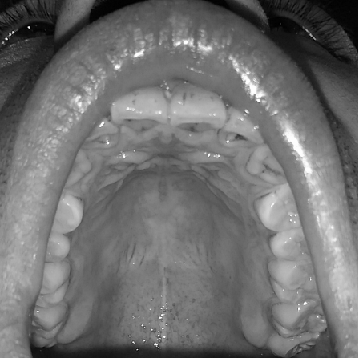

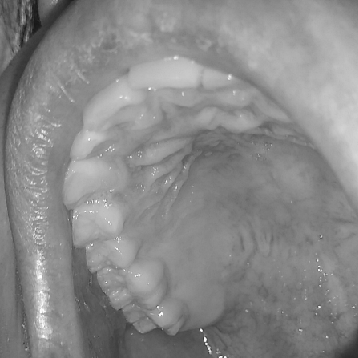

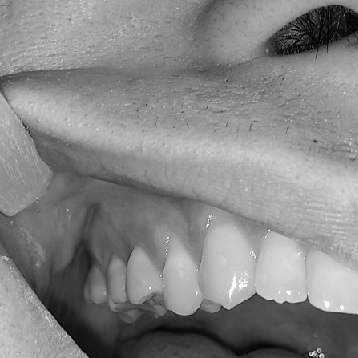

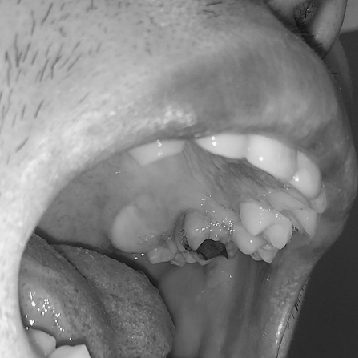

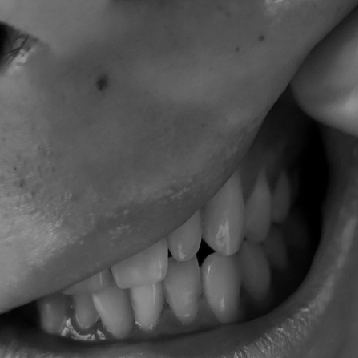

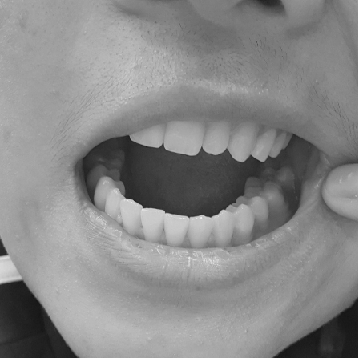

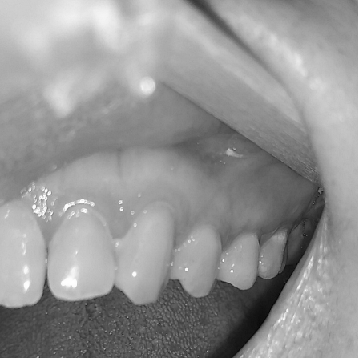

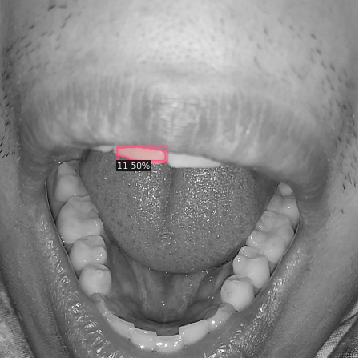

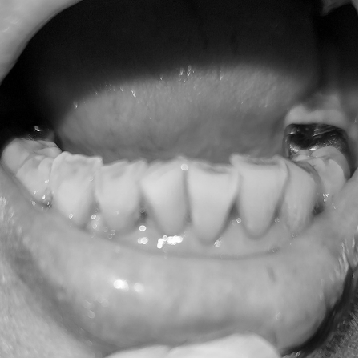

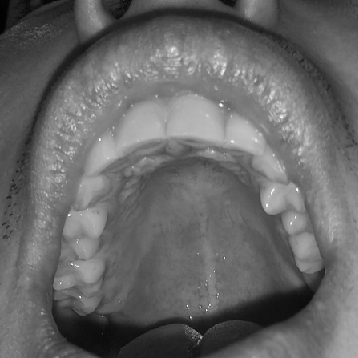

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=teeths_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='./data/images', json_file='./data/trainval.json', name='fruits_nuts', thing_classes=['date', 'fig', 'hazelnut'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2})

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.09,fps:10.79
